<a href="https://colab.research.google.com/github/cloverbunny/cccf2025/blob/main/JC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setup



In [ ]:
# Install BigQuery library
!pip install --quiet google-cloud-bigquery
import pandas as pd
from matplotlib import pyplot as plt

# Authenticate your Google account
from google.colab import auth
auth.authenticate_user()


In [ ]:
# Import BigQuery client
from google.cloud import bigquery

# Replace with your own project ID (must have BigQuery enabled there)
PROJECT_ID = "silent-bolt-397621"

# Create client under your project
client = bigquery.Client(project=PROJECT_ID)

#Import Data


In [52]:
#QUERY TO BRING IN PROCEDURE EVENTS

query = """
-- Define the procedures you care about
WITH selected_items AS (
  SELECT itemid, label
  FROM `physionet-data.mimiciv_3_1_icu.d_items`
  WHERE label IN (
    'Chest X-Ray',
    'Portable Chest X-Ray',
    'EKG',
    'Arterial Line',
    'Blood Cultured',
    'Multi Lumen',
    'Foley Catheter',
    'PICC Line',
    'Urine Culture',
    'Ultrasound',
    'PA Catheter',
    'Cordis/Introducer',
    'Stool Culture',
    'Sheath (Venous)',
    'MAC',
    'Temporary Pacemaker Wires Inserted',
    'Temporary Pacemaker Wires Discontinued'
  )
),
-- Get all ICU stays with LOS (filtered), APSIII score, and hospital mortality
stays AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    i.los,
    a.apsiii,
    a.apsiii_prob,
    adm.hospital_expire_flag
  FROM `physionet-data.mimiciv_3_1_icu.icustays` i
  LEFT JOIN `physionet-data.mimiciv_3_1_derived.apsiii` a
    ON i.stay_id = a.stay_id
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` adm
    ON i.subject_id = adm.subject_id
    AND i.hadm_id = adm.hadm_id
  WHERE i.outtime IS NOT NULL
    AND i.los > (2/24)
),
-- Count selected procedures per stay
proc_counts AS (
  SELECT
    pe.subject_id,
    pe.hadm_id,
    pe.stay_id,
    di.label AS item_label,
    COUNT(*) AS event_count
  FROM `physionet-data.mimiciv_3_1_icu.procedureevents` pe
  INNER JOIN selected_items di
    ON pe.itemid = di.itemid
  GROUP BY pe.subject_id, pe.hadm_id, pe.stay_id, di.label
),
-- Get cardiac catheterization counts per stay
cath_counts AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    COUNT(*) AS cardiac_cath_count
  FROM `physionet-data.mimiciv_3_1_icu.icustays` i
  JOIN `physionet-data.mimiciv_3_1_hosp.procedures_icd` p
    ON i.subject_id = p.subject_id
    AND i.hadm_id = p.hadm_id
  JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_procedures` d
    ON p.icd_code = d.icd_code
  WHERE d.long_title IN (
      'Left heart cardiac catheterization',
      'Combined right and left heart cardiac catheterization'
    )
  GROUP BY i.subject_id, i.hadm_id, i.stay_id
)
-- Pivot: one row per stay, one column per procedure
SELECT
  s.subject_id,
  s.hadm_id,
  s.stay_id,
  s.los,
  s.apsiii,
  s.apsiii_prob,
  s.hospital_expire_flag,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Chest X-Ray' THEN pc.event_count END), 0) AS chest_xray_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Portable Chest X-Ray' THEN pc.event_count END), 0) AS portable_chest_xray_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'EKG' THEN pc.event_count END), 0) AS ekg_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Arterial Line' THEN pc.event_count END), 0) AS arterial_line_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Blood Cultured' THEN pc.event_count END), 0) AS blood_cultured_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Multi Lumen' THEN pc.event_count END), 0) AS multi_lumen_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Foley Catheter' THEN pc.event_count END), 0) AS foley_catheter_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'PICC Line' THEN pc.event_count END), 0) AS picc_line_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Urine Culture' THEN pc.event_count END), 0) AS urine_culture_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Ultrasound' THEN pc.event_count END), 0) AS ultrasound_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'PA Catheter' THEN pc.event_count END), 0) AS pa_catheter_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Cordis/Introducer' THEN pc.event_count END), 0) AS cordis_introducer_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Stool Culture' THEN pc.event_count END), 0) AS stool_culture_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Sheath (Venous)' THEN pc.event_count END), 0) AS sheath_venous_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'MAC' THEN pc.event_count END), 0) AS mac_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Temporary Pacemaker Wires Inserted' THEN pc.event_count END), 0) AS temp_pacemaker_inserted_count,
  COALESCE(SUM(CASE WHEN pc.item_label = 'Temporary Pacemaker Wires Discontinued' THEN pc.event_count END), 0) AS temp_pacemaker_discontinued_count,
  COALESCE(cc.cardiac_cath_count, 0) AS cardiac_cath_count
FROM stays s
LEFT JOIN proc_counts pc
  ON s.subject_id = pc.subject_id
  AND s.hadm_id = pc.hadm_id
  AND s.stay_id = pc.stay_id
LEFT JOIN cath_counts cc
  ON s.subject_id = cc.subject_id
  AND s.hadm_id = cc.hadm_id
  AND s.stay_id = cc.stay_id
GROUP BY s.subject_id, s.hadm_id, s.stay_id, s.los, s.apsiii, s.apsiii_prob, s.hospital_expire_flag, cc.cardiac_cath_count
ORDER BY s.subject_id, s.hadm_id, s.stay_id
"""

query_job = client.query(query)
df = query_job.to_dataframe()
df

,subject_id,hadm_id,stay_id,los,apsiii,apsiii_prob,hospital_expire_flag,chest_xray_count,portable_chest_xray_count,ekg_count,...,urine_culture_count,ultrasound_count,pa_catheter_count,cordis_introducer_count,stool_culture_count,sheath_venous_count,mac_count,temp_pacemaker_inserted_count,temp_pacemaker_discontinued_count,cardiac_cath_count
0,10000032,29079034,39553978,0.410266,54,0.131935,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10000690,25860671,37081114,3.893252,52,0.121481,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,10000980,26913865,39765666,0.497535,32,0.050995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10001217,24597018,37067082,1.118032,22,0.032412,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001217,27703517,34592300,0.948113,18,0.026980,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94129,19999442,26785317,32336619,6.950370,28,0.042586,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
94130,19999625,25304202,31070865,0.960741,57,0.149036,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94131,19999828,25744818,36075953,1.790995,26,0.038894,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94132,19999840,21033226,38978960,5.297766,88,0.431160,1,3,0,2,...,1,0,0,0,0,0,0,0,0,0


#Wrangle Data

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define procedure prices
procedure_prices = {
    'chest_xray_count': 750,  # CXR
    'portable_chest_xray_count': 750,  # Also CXR
    'ekg_count': 500,  # EKG
    'arterial_line_count': 700,  # Art_line
    'blood_cultured_count': 150,  # Blood_culture
    'multi_lumen_count': 2000,  # Central_venous_catheter
    'foley_catheter_count': 200,  # Foley_catheter
    'picc_line_count': 1000,  # PICC_line
    # Note: CBC and BMP labs not in the current procedure list
}

# Calculate cost for each procedure type
for procedure, price in procedure_prices.items():
    df[f'{procedure}_cost'] = df[procedure] * price

# Calculate total procedure cost per stay
cost_columns = [f'{proc}_cost' for proc in procedure_prices.keys()]
df['total_procedure_cost'] = df[cost_columns].sum(axis=1)

# Calculate cost per day of ICU stay
df['procedure_cost_per_day'] = df['total_procedure_cost'] / df['los']

# Calculate cost normalized by APSIII score (higher APSIII = sicker patients)
df['procedure_cost_per_apsiii'] = df['total_procedure_cost'] / df['apsiii']

# Calculate cost normalized by both LOS and APSIII
df['procedure_cost_per_day_per_apsiii'] = df['procedure_cost_per_day'] / df['apsiii']

df



In [29]:
# String suffix to match
suffix = "_count"

# Drop columns that end with the given suffix
cols_to_drop = [col for col in df.columns if col.endswith(suffix)]
df_drop = df.drop(columns=cols_to_drop)

# Creating a DataFrame
df_drop_pd = pd.DataFrame(df_drop)

# Writing to a CSV file
df_drop_pd.to_csv('output_pandas.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
df_drop.head()

,subject_id,hadm_id,stay_id,los,apsiii,apsiii_prob,hospital_expire_flag,chest_xray_count_cost,portable_chest_xray_count_cost,ekg_count_cost,arterial_line_count_cost,blood_cultured_count_cost,multi_lumen_count_cost,foley_catheter_count_cost,picc_line_count_cost,total_procedure_cost,procedure_cost_per_day,procedure_cost_per_apsiii,procedure_cost_per_day_per_apsiii
0,10000032,29079034,39553978,0.410266,54,0.131935,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,10000690,25860671,37081114,3.893252,52,0.121481,0,750,0,500,0,150,0,0,0,1400,359.596524,26.923077,6.915318
2,10000980,26913865,39765666,0.497535,32,0.050995,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,10001217,24597018,37067082,1.118032,22,0.032412,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,10001217,27703517,34592300,0.948113,18,0.026980,0,0,0,0,0,0,0,0,1000,1000,1054.726125,55.555556,58.595896


In [54]:
import pandas as pd
from builtins import print as builtin_print

# Assuming you've loaded your query results into a dataframe called 'df'

# Create a binary indicator for whether cardiac cath occurred
df['had_cardiac_cath'] = (df['cardiac_cath_count'] > 0).astype(int)

# Analyze EKG counts by cardiac cath status
builtin_print("EKG Statistics by Cardiac Catheterization Status:")
builtin_print(df.groupby('had_cardiac_cath')['ekg_count'].describe())

builtin_print("\n" + "="*60)
builtin_print("Cardiac Cath Rate by EKG Count:")
builtin_print(df.groupby('ekg_count')['had_cardiac_cath'].agg(['count', 'sum', 'mean']))

# Or create bins for EKG counts
df['ekg_bins'] = pd.cut(df['ekg_count'],
                         bins=[0, 1, 3, 5, 10, float('inf')],
                         labels=['0-1', '2-3', '4-5', '6-10', '10+'],
                         include_lowest=True)

builtin_print("\n" + "="*60)
builtin_print("Cardiac Cath Rate by EKG Count Bins:")
cath_by_ekg = df.groupby('ekg_bins', observed=True).agg({
    'had_cardiac_cath': ['count', 'sum', 'mean']
})
builtin_print(cath_by_ekg)

EKG Statistics by Cardiac Catheterization Status:
                    count      mean       std  min  25%  50%  75%   max
had_cardiac_cath                                                       
0                 91203.0  0.433286  0.929707  0.0  0.0  0.0  1.0  34.0
1                  2931.0  0.949505  1.152609  0.0  0.0  1.0  1.0  16.0

Cardiac Cath Rate by EKG Count:
           count   sum      mean
ekg_count                       
0          66200  1129  0.017054
1          19967  1256  0.062904
2           4963   326  0.065686
3           1557   112  0.071933
4            678    52  0.076696
5            348    33  0.094828
6            171    13  0.076023
7            106     4  0.037736
8             41     2  0.048780
9             33     2  0.060606
10            26     1  0.038462
11            10     0  0.000000
12             8     0  0.000000
13             6     0  0.000000
14             4     0  0.000000
15             6     0  0.000000
16             3     1  0.333333
17

In [56]:
from builtins import print as builtin_print

# Option 1: EKGs in patients who never got a cardiac cath
# (assuming EKGs were done to evaluate for cath need)
useless_ekgs_no_cath = df[df['had_cardiac_cath'] == 0]['ekg_count'].sum()
builtin_print(f"Total EKGs in patients without cardiac cath: {useless_ekgs_no_cath}")

# Option 2: "Excess" EKGs in patients who did get a cath
# (assuming only 1 EKG is needed to decide on cath)
excess_ekgs_with_cath = df[df['had_cardiac_cath'] == 1].apply(
    lambda row: max(0, row['ekg_count'] - 1), axis=1
).sum()
builtin_print(f"Excess EKGs in patients with cardiac cath (beyond first): {excess_ekgs_with_cath}")

# Option 3: All EKGs beyond the first one in ANY patient
excess_ekgs_all = df.apply(lambda row: max(0, row['ekg_count'] - 1), axis=1).sum()
builtin_print(f"All EKGs beyond the first in each patient: {excess_ekgs_all}")

# Summary
total_ekgs = df['ekg_count'].sum()
builtin_print(f"\nTotal EKGs performed: {total_ekgs}")
builtin_print(f"Patients with at least 1 EKG: {(df['ekg_count'] > 0).sum()}")
builtin_print(f"Average EKGs per patient: {df['ekg_count'].mean():.2f}")

# Detailed breakdown
builtin_print("\n" + "="*60)
builtin_print("Breakdown by cardiac cath status:")
builtin_print("="*60)
for cath_status in [0, 1]:
    status_name = "No Cath" if cath_status == 0 else "Had Cath"
    subset = df[df['had_cardiac_cath'] == cath_status]
    builtin_print(f"\n{status_name}:")
    builtin_print(f"  Total patients: {len(subset)}")
    builtin_print(f"  Total EKGs: {subset['ekg_count'].sum()}")
    builtin_print(f"  Average EKGs per patient: {subset['ekg_count'].mean():.2f}")
    builtin_print(f"  Patients with 0 EKGs: {(subset['ekg_count'] == 0).sum()}")
    builtin_print(f"  Patients with 1 EKG: {(subset['ekg_count'] == 1).sum()}")
    builtin_print(f"  Patients with 2+ EKGs: {(subset['ekg_count'] >= 2).sum()}")

Total EKGs in patients without cardiac cath: 39517
Excess EKGs in patients with cardiac cath (beyond first): 981
All EKGs beyond the first in each patient: 14366

Total EKGs performed: 42300
Patients with at least 1 EKG: 27934
Average EKGs per patient: 0.45

Breakdown by cardiac cath status:

No Cath:
  Total patients: 91203
  Total EKGs: 39517
  Average EKGs per patient: 0.43
  Patients with 0 EKGs: 65071
  Patients with 1 EKG: 18711
  Patients with 2+ EKGs: 7421

Had Cath:
  Total patients: 2931
  Total EKGs: 2783
  Average EKGs per patient: 0.95
  Patients with 0 EKGs: 1129
  Patients with 1 EKG: 1256
  Patients with 2+ EKGs: 546


Total EKGs in patients without cardiac cath: 39517
Excess EKGs in patients with cardiac cath (beyond first): 981
All EKGs beyond the first in each patient: 14366

Total EKGs performed: 42300
Patients with at least 1 EKG: 27934
Average EKGs per patient: 0.45

Breakdown by cardiac cath status:

No Cath:
  Total patients: 91203
  Total EKGs: 39517
  Average EKGs per patient: 0.43
  Patients with 0 EKGs: 65071
  Patients with 1 EKG: 18711
  Patients with 2+ EKGs: 7421

Had Cath:
  Total patients: 2931
  Total EKGs: 2783
  Average EKGs per patient: 0.95
  Patients with 0 EKGs: 1129
  Patients with 1 EKG: 1256
  Patients with 2+ EKGs: 546


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/ekg_utilization_analysis.png'

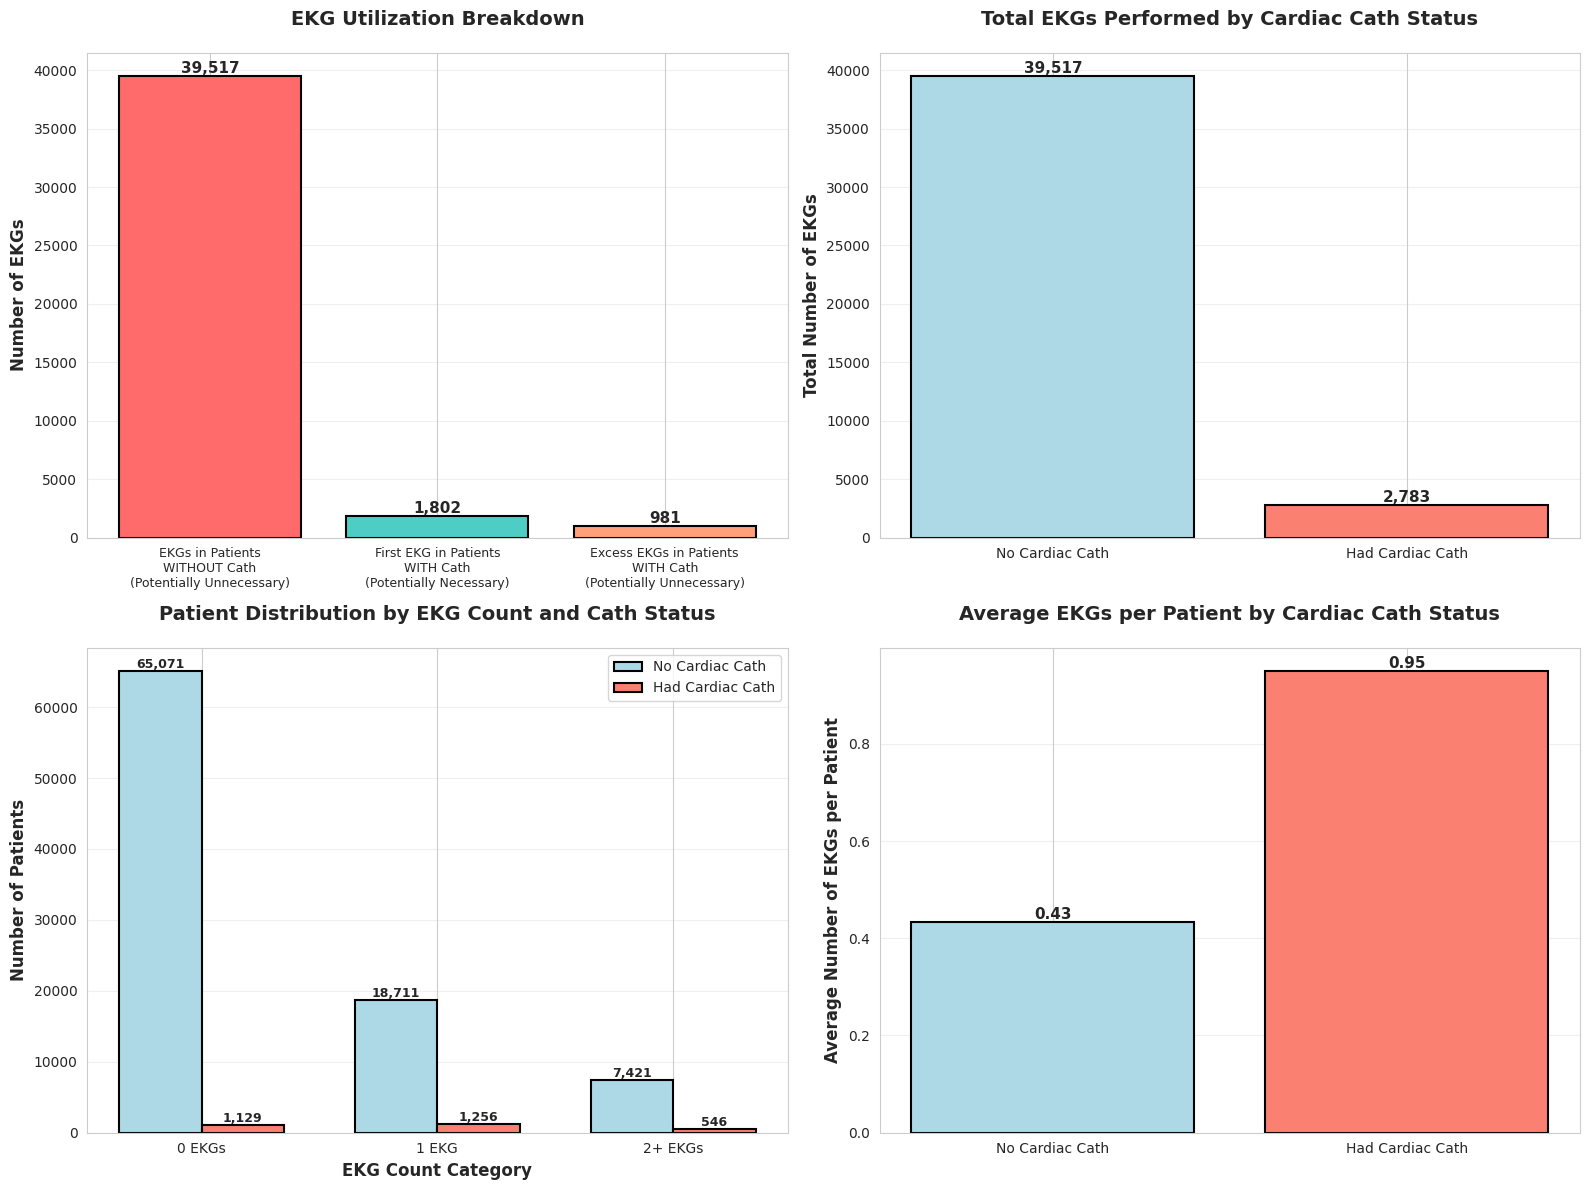

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from builtins import print as builtin_print

# Calculations
useless_ekgs_no_cath = df[df['had_cardiac_cath'] == 0]['ekg_count'].sum()
builtin_print(f"Total EKGs in patients without cardiac cath: {useless_ekgs_no_cath}")

excess_ekgs_with_cath = df[df['had_cardiac_cath'] == 1].apply(
    lambda row: max(0, row['ekg_count'] - 1), axis=1
).sum()
builtin_print(f"Excess EKGs in patients with cardiac cath (beyond first): {excess_ekgs_with_cath}")

excess_ekgs_all = df.apply(lambda row: max(0, row['ekg_count'] - 1), axis=1).sum()
builtin_print(f"All EKGs beyond the first in each patient: {excess_ekgs_all}")

total_ekgs = df['ekg_count'].sum()
builtin_print(f"\nTotal EKGs performed: {total_ekgs}")
builtin_print(f"Patients with at least 1 EKG: {(df['ekg_count'] > 0).sum()}")
builtin_print(f"Average EKGs per patient: {df['ekg_count'].mean():.2f}")

# Detailed breakdown
builtin_print("\n" + "="*60)
builtin_print("Breakdown by cardiac cath status:")
builtin_print("="*60)
for cath_status in [0, 1]:
    status_name = "No Cath" if cath_status == 0 else "Had Cath"
    subset = df[df['had_cardiac_cath'] == cath_status]
    builtin_print(f"\n{status_name}:")
    builtin_print(f"  Total patients: {len(subset)}")
    builtin_print(f"  Total EKGs: {subset['ekg_count'].sum()}")
    builtin_print(f"  Average EKGs per patient: {subset['ekg_count'].mean():.2f}")
    builtin_print(f"  Patients with 0 EKGs: {(subset['ekg_count'] == 0).sum()}")
    builtin_print(f"  Patients with 1 EKG: {(subset['ekg_count'] == 1).sum()}")
    builtin_print(f"  Patients with 2+ EKGs: {(subset['ekg_count'] >= 2).sum()}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total EKGs breakdown (potentially unnecessary vs necessary)
ax1 = axes[0, 0]

# Calculate necessary vs excess EKGs
no_cath_subset = df[df['had_cardiac_cath'] == 0]
with_cath_subset = df[df['had_cardiac_cath'] == 1]

# First EKG for patients with cath (potentially necessary)
first_ekgs_with_cath = (with_cath_subset['ekg_count'] >= 1).sum()
# All EKGs for patients without cath (potentially unnecessary)
total_ekgs_no_cath = no_cath_subset['ekg_count'].sum()
# Excess EKGs for patients with cath
excess_with_cath = excess_ekgs_with_cath

categories1 = ['EKGs in Patients\nWITHOUT Cath\n(Potentially Unnecessary)',
               'First EKG in Patients\nWITH Cath\n(Potentially Necessary)',
               'Excess EKGs in Patients\nWITH Cath\n(Potentially Unnecessary)']
values1 = [total_ekgs_no_cath, first_ekgs_with_cath, excess_with_cath]
colors1 = ['#ff6b6b', '#4ecdc4', '#ffa07a']

bars1 = ax1.bar(categories1, values1, color=colors1, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of EKGs', fontsize=12, fontweight='bold')
ax1.set_title('EKG Utilization Breakdown', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.tick_params(axis='x', labelsize=9)

# Plot 2: Total EKGs by Cath Status
ax2 = axes[0, 1]

no_cath_ekgs = df[df['had_cardiac_cath'] == 0]['ekg_count'].sum()
with_cath_ekgs = df[df['had_cardiac_cath'] == 1]['ekg_count'].sum()

categories2 = ['No Cardiac Cath', 'Had Cardiac Cath']
values2 = [no_cath_ekgs, with_cath_ekgs]
colors2 = ['lightblue', 'salmon']

bars2 = ax2.bar(categories2, values2, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total Number of EKGs', fontsize=12, fontweight='bold')
ax2.set_title('Total EKGs Performed by Cardiac Cath Status', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Patient distribution by EKG count
ax3 = axes[1, 0]

categories3 = ['0 EKGs', '1 EKG', '2+ EKGs']
no_cath_counts = [
    (no_cath_subset['ekg_count'] == 0).sum(),
    (no_cath_subset['ekg_count'] == 1).sum(),
    (no_cath_subset['ekg_count'] >= 2).sum()
]
with_cath_counts = [
    (with_cath_subset['ekg_count'] == 0).sum(),
    (with_cath_subset['ekg_count'] == 1).sum(),
    (with_cath_subset['ekg_count'] >= 2).sum()
]

x3 = np.arange(len(categories3))
width3 = 0.35

bars3a = ax3.bar(x3 - width3/2, no_cath_counts, width3, label='No Cardiac Cath',
                 color='lightblue', edgecolor='black', linewidth=1.5)
bars3b = ax3.bar(x3 + width3/2, with_cath_counts, width3, label='Had Cardiac Cath',
                 color='salmon', edgecolor='black', linewidth=1.5)

ax3.set_xlabel('EKG Count Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax3.set_title('Patient Distribution by EKG Count and Cath Status', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x3)
ax3.set_xticklabels(categories3)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Average EKGs per patient
ax4 = axes[1, 1]

avg_no_cath = no_cath_subset['ekg_count'].mean()
avg_with_cath = with_cath_subset['ekg_count'].mean()

categories4 = ['No Cardiac Cath', 'Had Cardiac Cath']
values4 = [avg_no_cath, avg_with_cath]
colors4 = ['lightblue', 'salmon']

bars4 = ax4.bar(categories4, values4, color=colors4, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Average Number of EKGs per Patient', fontsize=12, fontweight='bold')
ax4.set_title('Average EKGs per Patient by Cardiac Cath Status', fontsize=14, fontweight='bold', pad=20)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/ekg_utilization_analysis.png', dpi=300, bbox_inches='tight')
builtin_print("\n✓ Visualization saved to /mnt/user-data/outputs/ekg_utilization_analysis.png")
plt.show()

# ============================================================================
# Additional single plot: Percentage breakdown
# ============================================================================

fig2, ax = plt.subplots(figsize=(10, 6))

# Calculate percentages
potentially_unnecessary = total_ekgs_no_cath + excess_with_cath
potentially_necessary = first_ekgs_with_cath
pct_unnecessary = (potentially_unnecessary / total_ekgs) * 100
pct_necessary = (potentially_necessary / total_ekgs) * 100

categories_pct = ['Potentially Necessary\n(1st EKG for Cath Patients)',
                  'Potentially Unnecessary\n(All other EKGs)']
values_pct = [potentially_necessary, potentially_unnecessary]
percentages = [pct_necessary, pct_unnecessary]
colors_pct = ['#4ecdc4', '#ff6b6b']

bars_pct = ax.bar(categories_pct, values_pct, color=colors_pct, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of EKGs', fontsize=13, fontweight='bold')
ax.set_title('EKG Necessity Assessment\n(Based on Association with Cardiac Catheterization)',
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Add value and percentage labels
for i, bar in enumerate(bars_pct):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({percentages[i]:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/ekg_necessity_breakdown.png', dpi=300, bbox_inches='tight')
builtin_print("✓ Visualization saved to /mnt/user-data/outputs/ekg_necessity_breakdown.png")
plt.show()

Total EKGs in patients without cardiac cath: 39517
Excess EKGs in patients with cardiac cath (beyond first): 981
All EKGs beyond the first in each patient: 14366

Total EKGs performed: 42300
Patients with at least 1 EKG: 27934
Average EKGs per patient: 0.45

Breakdown by cardiac cath status:

No Cath:
  Total patients: 91203
  Total EKGs: 39517
  Average EKGs per patient: 0.43
  Patients with 0 EKGs: 65071
  Patients with 1 EKG: 18711
  Patients with 2+ EKGs: 7421

Had Cath:
  Total patients: 2931
  Total EKGs: 2783
  Average EKGs per patient: 0.95
  Patients with 0 EKGs: 1129
  Patients with 1 EKG: 1256
  Patients with 2+ EKGs: 546


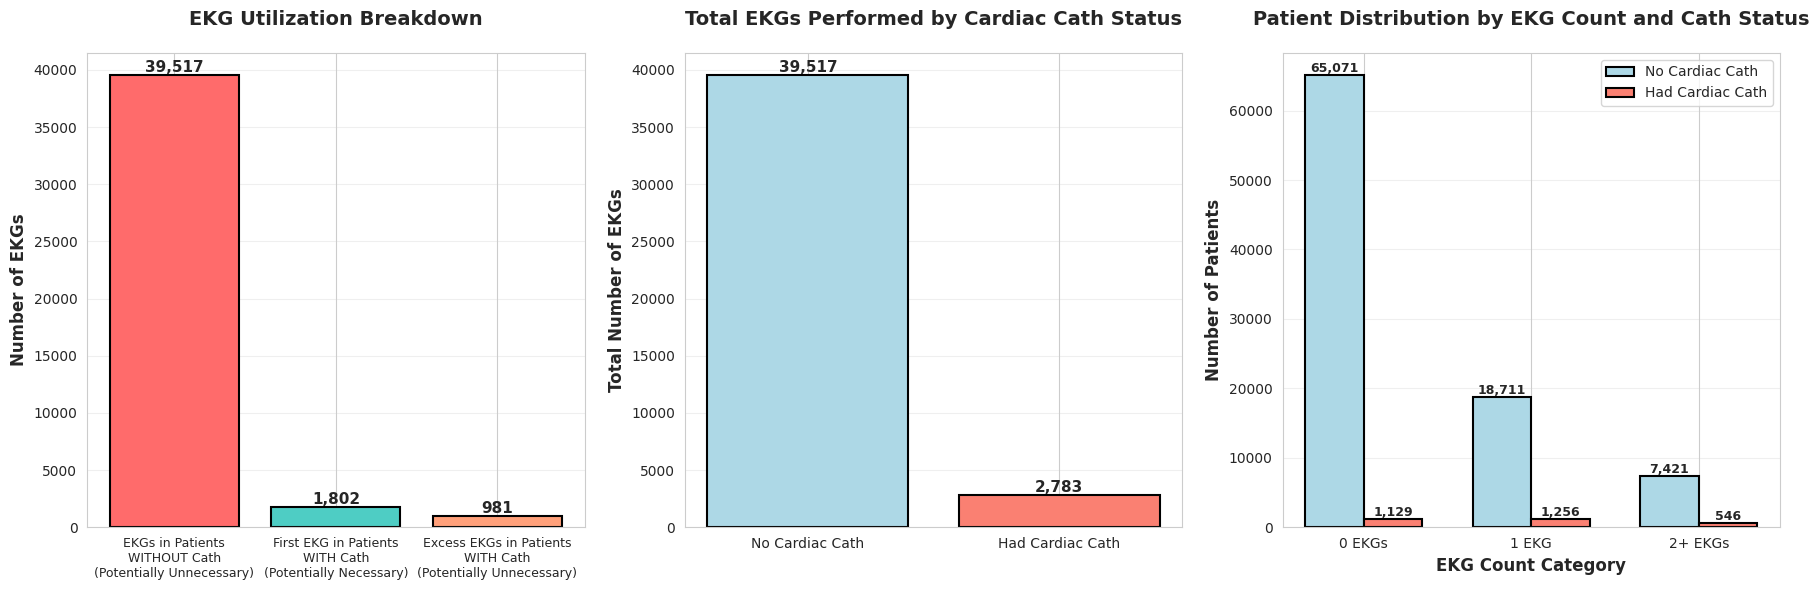

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from builtins import print as builtin_print

# Calculations
useless_ekgs_no_cath = df[df['had_cardiac_cath'] == 0]['ekg_count'].sum()
builtin_print(f"Total EKGs in patients without cardiac cath: {useless_ekgs_no_cath}")

excess_ekgs_with_cath = df[df['had_cardiac_cath'] == 1].apply(
    lambda row: max(0, row['ekg_count'] - 1), axis=1
).sum()
builtin_print(f"Excess EKGs in patients with cardiac cath (beyond first): {excess_ekgs_with_cath}")

excess_ekgs_all = df.apply(lambda row: max(0, row['ekg_count'] - 1), axis=1).sum()
builtin_print(f"All EKGs beyond the first in each patient: {excess_ekgs_all}")

total_ekgs = df['ekg_count'].sum()
builtin_print(f"\nTotal EKGs performed: {total_ekgs}")
builtin_print(f"Patients with at least 1 EKG: {(df['ekg_count'] > 0).sum()}")
builtin_print(f"Average EKGs per patient: {df['ekg_count'].mean():.2f}")

# Detailed breakdown
builtin_print("\n" + "="*60)
builtin_print("Breakdown by cardiac cath status:")
builtin_print("="*60)
for cath_status in [0, 1]:
    status_name = "No Cath" if cath_status == 0 else "Had Cath"
    subset = df[df['had_cardiac_cath'] == cath_status]
    builtin_print(f"\n{status_name}:")
    builtin_print(f"  Total patients: {len(subset)}")
    builtin_print(f"  Total EKGs: {subset['ekg_count'].sum()}")
    builtin_print(f"  Average EKGs per patient: {subset['ekg_count'].mean():.2f}")
    builtin_print(f"  Patients with 0 EKGs: {(subset['ekg_count'] == 0).sum()}")
    builtin_print(f"  Patients with 1 EKG: {(subset['ekg_count'] == 1).sum()}")
    builtin_print(f"  Patients with 2+ EKGs: {(subset['ekg_count'] >= 2).sum()}")

# ============================================================================
# VISUALIZATIONS - First 3 Plots Only
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate subsets
no_cath_subset = df[df['had_cardiac_cath'] == 0]
with_cath_subset = df[df['had_cardiac_cath'] == 1]

# Plot 1: Total EKGs breakdown (potentially unnecessary vs necessary)
ax1 = axes[0]

# First EKG for patients with cath (potentially necessary)
first_ekgs_with_cath = (with_cath_subset['ekg_count'] >= 1).sum()
# All EKGs for patients without cath (potentially unnecessary)
total_ekgs_no_cath = no_cath_subset['ekg_count'].sum()
# Excess EKGs for patients with cath
excess_with_cath = excess_ekgs_with_cath

categories1 = ['EKGs in Patients\nWITHOUT Cath\n(Potentially Unnecessary)',
               'First EKG in Patients\nWITH Cath\n(Potentially Necessary)',
               'Excess EKGs in Patients\nWITH Cath\n(Potentially Unnecessary)']
values1 = [total_ekgs_no_cath, first_ekgs_with_cath, excess_with_cath]
colors1 = ['#ff6b6b', '#4ecdc4', '#ffa07a']

bars1 = ax1.bar(categories1, values1, color=colors1, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of EKGs', fontsize=12, fontweight='bold')
ax1.set_title('EKG Utilization Breakdown', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.tick_params(axis='x', labelsize=9)

# Plot 2: Total EKGs by Cath Status
ax2 = axes[1]

no_cath_ekgs = df[df['had_cardiac_cath'] == 0]['ekg_count'].sum()
with_cath_ekgs = df[df['had_cardiac_cath'] == 1]['ekg_count'].sum()

categories2 = ['No Cardiac Cath', 'Had Cardiac Cath']
values2 = [no_cath_ekgs, with_cath_ekgs]
colors2 = ['lightblue', 'salmon']

bars2 = ax2.bar(categories2, values2, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total Number of EKGs', fontsize=12, fontweight='bold')
ax2.set_title('Total EKGs Performed by Cardiac Cath Status', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Patient distribution by EKG count
ax3 = axes[2]

categories3 = ['0 EKGs', '1 EKG', '2+ EKGs']
no_cath_counts = [
    (no_cath_subset['ekg_count'] == 0).sum(),
    (no_cath_subset['ekg_count'] == 1).sum(),
    (no_cath_subset['ekg_count'] >= 2).sum()
]
with_cath_counts = [
    (with_cath_subset['ekg_count'] == 0).sum(),
    (with_cath_subset['ekg_count'] == 1).sum(),
    (with_cath_subset['ekg_count'] >= 2).sum()
]

x3 = np.arange(len(categories3))
width3 = 0.35

bars3a = ax3.bar(x3 - width3/2, no_cath_counts, width3, label='No Cardiac Cath',
                 color='lightblue', edgecolor='black', linewidth=1.5)
bars3b = ax3.bar(x3 + width3/2, with_cath_counts, width3, label='Had Cardiac Cath',
                 color='salmon', edgecolor='black', linewidth=1.5)

ax3.set_xlabel('EKG Count Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax3.set_title('Patient Distribution by EKG Count and Cath Status', fontsize=14, fontweight='bold', pad=20)
ax3.set_xticks(x3)
ax3.set_xticklabels(categories3)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('./ekg_utilization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()